In [1]:
# !pip install functorch
# print("--> Restarting colab instance") 
# get_ipython().kernel.do_shutdown(True)

In [2]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
%matplotlib inline
import sys
sys.path.append("../src/")

from NNApproximator import NNApproximator
from losses import compute_data_loss_force, compute_PINN_loss

# Load training data

In [3]:
import pandas as pd

# df = pd.read_csv('k=70_L=5_N=5.csv')
# df = pd.read_csv('k=50_L=5_N=5_M=1.csv')
df = pd.read_csv('k=50_L=7_N=5_M=1_t=40s.csv')
positions = df[['r0_x', 'r0_y', 'r1_x', 'r1_y', 'r2_x', 'r2_y', 'r3_x', 'r3_y','r4_x','r4_y']]
forces = df[['rddot1_x','rddot1_y','rddot2_x','rddot2_y','rddot3_x','rddot3_y']]

position_stack = np.vstack((
    positions[['r0_x','r0_y','r1_x','r1_y','r2_x','r2_y']].to_numpy(),
    positions[['r1_x','r1_y','r2_x','r2_y','r3_x','r3_y']].to_numpy(),
    positions[['r2_x','r2_y','r3_x','r3_y','r4_x','r4_y']].to_numpy()
))
forces_stack = np.vstack((
    forces[['rddot1_x','rddot1_y']].to_numpy(),
    forces[['rddot2_x','rddot2_y']].to_numpy(),
    forces[['rddot3_x','rddot3_y']].to_numpy()
))

x = torch.from_numpy(position_stack.copy()).float()
F = torch.from_numpy(forces_stack.copy()).float()

X_SCALE = 3.0
V_SCALE = 50.0 * X_SCALE**2
F_SCALE = 30.0 # V_SCALE / X_SCALE
GRAD_F_SCALE = F_SCALE / X_SCALE

### Define train_model

In [4]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

def train_model(model, data_loss_fn, PINN_loss_fn, val_loss_fn, learning_rate=0.0001, max_epochs=1000, USE_BFGS=False, weight_decay=5e-5):
  model.train()
  tr_losses = []
  data_losses = []
  PINN_losses = []
  val_losses  = []
  k_values = []

  # reference on torch.LBFGS usage
  # https://gist.github.com/tuelwer/0b52817e9b6251d940fd8e2921ec5e20
  # USE_BFGS = False

  if USE_BFGS:
    optimizer = torch.optim.LBFGS(model.parameters())
    print("Using BFGS optimizer ... ")
    log_iter = 10
    def closure():
        optimizer.zero_grad()
        objective = data_loss_fn(model) + PINN_loss_fn(model)
        objective.backward()
        return objective
  else:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    print("Using Adam optimizer ... ")
    log_iter = 1000

  # scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=3000, eta_min=1e-6)
  min_loss = 1e9
  last_save = 0

  for epoch in range(max_epochs):
    data_loss = data_loss_fn(model)
    PINN_loss = PINN_loss_fn(model)
    val_loss  = val_loss_fn(model)
    loss = data_loss + PINN_loss
    if USE_BFGS:
      optimizer.step(closure)
    else:
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    # scheduler.step()

    if epoch % log_iter == 0:
      # print(f"Epoch: {epoch} - Loss: {float(loss):>7f} - Data: {float(data_loss):>7f} - PINN: {float(PINN_loss):>7f}")
      print(f"Epoch: {epoch} - Loss: {float(loss):>7f} - Data: {float(data_loss):>7f} - PINN: {float(PINN_loss):>7f} - k: {float(model.k.detach()):>7f}")
      print(f"Validation loss: {float(val_loss):>7f}")
    tr_losses.append(loss.detach().numpy())
    data_losses.append(data_loss.detach().numpy())
    PINN_losses.append(PINN_loss.detach().numpy())
    val_losses.append(val_loss.detach().numpy())
    k_values.append(float(model.k.detach()))

    if epoch > 2000 and val_loss.item() < 0.99 * min_loss:
      min_loss = val_loss.item()
      if (epoch - last_save) > 10:
        torch.save(model.state_dict(), 'checkpoint.pth')
        last_save = epoch

  loss_0 = 5954.499512  # tr_losses[0]
  # loss_0 = tr_losses[0]

  fig, ax = plt.subplots(2, 1, figsize=(9,12))

  SMALL_SIZE = 14
  MEDIUM_SIZE = 18
  # BIGGER_SIZE = 16
  LINE_WIDTH = 2

  plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
  plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
  plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
  plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
  plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
  plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
  # plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

  ax[0].semilogy(np.array(tr_losses) / loss_0, label="Total loss", linewidth=LINE_WIDTH)
  ax[0].semilogy(np.array(data_losses) / loss_0, label="Loss-data", linewidth=LINE_WIDTH)
  ax[0].semilogy(np.array(PINN_losses) / loss_0, label="Loss-PINN", linewidth=LINE_WIDTH)
  # ax[0].semilogy(val_losses, label="Val")
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Normalized loss, $\mathcal{L}$")
  ax[0].legend()

  TRUE_K_VALUE = 70.0

  ax[1].plot(k_values, label="$k_{NN}$")
  ax[1].plot(np.ones_like(np.array(k_values)) * TRUE_K_VALUE, label="$k^*$", linestyle='dashed', color='black')
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Model stiffness, $k_{NN}$")
  ax[1].legend()
  # ax[1].set_ylim([0.0, 90.0])

  print("Min loss: ", min_loss)

  return model, np.array(tr_losses), np.array(data_losses), np.array(PINN_losses), np.array(k_values)

### Select collocation points using (quasi)-monte carlo sampling

In [5]:
from scipy.stats import qmc

def get_LHS_sample(input_data, N):
  sampler = qmc.LatinHypercube(d=6)
  sample = sampler.random(n=N)

  data_xs = input_data #[:, indices]
  data_xbar = torch.mean(data_xs, dim=0)
  sample = qmc.scale(sample, (torch.min(data_xs - data_xbar - 1, dim=0)[0]).numpy(), (torch.max(data_xs - data_xbar + 1, dim=0)[0]).numpy()) + data_xbar.numpy()
  # plt.scatter(sample[:,0],sample[:,2], s=np.ones(sample.shape[0]))

  return sample

# Prepare training and collocation data

In [6]:
# The oracle model computes the true force vector for any input x.
# We can use it to both validate the loss implementations and check 
# the self-consistency of the chosen training/collocation dataset.

class OracleModel(NNApproximator):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return super()._get_force_truth(x)

x_tr = torch.vstack((
    x[   0: 500,:].clone(),
    x[4000:4500,:].clone(),
    x[8000:8500,:].clone()
))
y_tr = torch.vstack((
    F[   0: 500,:].clone(),
    F[4000:4500,:].clone(),
    F[8000:8500,:].clone()
))

x_va = torch.vstack((
    x[ 500: 2000,:].clone(),
    x[4500: 6000,:].clone(),
    x[8500:10000,:].clone()
))
y_va = torch.vstack((
    F[ 500: 2000,:].clone(),
    F[4500: 6000,:].clone(),
    F[8500:10000,:].clone()
))

x_te = torch.vstack((
    x[2000: 4000,:].clone(),
    x[6000: 8000,:].clone(),
    x[1000:12000,:].clone()
))
y_te = torch.vstack((
    F[2000: 4000,:].clone(),
    F[6000: 8000,:].clone(),
    F[1000:12000,:].clone()
))

mdl_o = OracleModel()

print(compute_data_loss_force(mdl_o, x_tr, y_tr))

x_tr += torch.randn_like(x_tr) * (torch.std(x_tr,dim=0) * 0.003)

print(compute_data_loss_force(mdl_o, x_tr, y_tr))

# sample_qmc = get_LHS_sample(x.detach(), 1024)
samples = x.detach().numpy() #np.vstack((sample_qmc, x_tr[:, :].detach()))
samples = torch.tensor(samples)
x_collocation = samples.float().requires_grad_(True)

print(compute_PINN_loss(mdl_o, x_collocation))

tensor(3.6767e-13)
tensor(0.0011)
tensor(9.7958e-12, grad_fn=<DivBackward0>)


# Train NN

Using Adam optimizer ... 
Epoch: 0 - Loss: 5954.499512 - Data: 942.310669 - PINN: 5012.188965 - k: 50.000000
Validation loss: 789.574219
Epoch: 1000 - Loss: 30.363316 - Data: 13.795539 - PINN: 16.567776 - k: 50.000000
Validation loss: 1.689135
Epoch: 2000 - Loss: 21.084316 - Data: 13.027978 - PINN: 8.056339 - k: 50.000000
Validation loss: 0.862942
Epoch: 3000 - Loss: 17.509333 - Data: 12.648565 - PINN: 4.860767 - k: 50.000000
Validation loss: 0.564555
Epoch: 4000 - Loss: 49.950466 - Data: 46.172066 - PINN: 3.778402 - k: 50.000000
Validation loss: 34.861389
Epoch: 5000 - Loss: 14.711328 - Data: 12.402251 - PINN: 2.309077 - k: 50.000000
Validation loss: 0.409853
Epoch: 6000 - Loss: 13.829999 - Data: 12.287529 - PINN: 1.542470 - k: 50.000000
Validation loss: 0.278002
Epoch: 7000 - Loss: 13.952315 - Data: 12.803061 - PINN: 1.149254 - k: 50.000000
Validation loss: 0.818468
Epoch: 8000 - Loss: 13.000682 - Data: 12.175577 - PINN: 0.825105 - k: 50.000000
Validation loss: 0.173599
Epoch: 9000 -

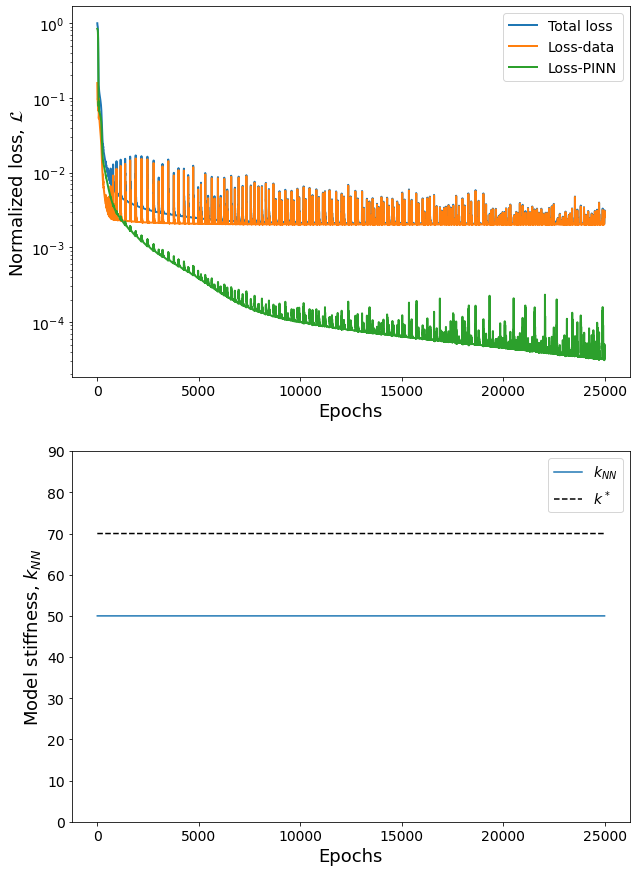

In [136]:
num_layer = 5
hidden_dim = 32
epoch = 25000
lr = 1e-3
model = NNApproximator(num_hidden=num_layer, dim_hidden=hidden_dim)
model.set_scale_x = X_SCALE
model.set_scale_f = F_SCALE
model.k.requires_grad = False

model, L_tr, L_data_tr, L_pinn_tr, _ = train_model(
    model,
    data_loss_fn=lambda model: 1e4 * compute_data_loss_force(model, x_tr, y_tr),
    PINN_loss_fn=lambda model: 1e2 * compute_PINN_loss(model, x_collocation),
    val_loss_fn =lambda model: 1e4 * compute_data_loss_force(model, x_va, y_va),
    learning_rate=lr,
    max_epochs=epoch,
    weight_decay=1e-3,
)

In [149]:
# from google.colab import files

torch.save(model.state_dict(), 'pretrain_final.pth')
model.load_state_dict(torch.load('checkpoint.pth'))
torch.save(model.state_dict(), 'pretrain_last_checkpoint.pth')
# model.load_state_dict(torch.load('pretrain_final.pth'))

# # download checkpoint file
# files.download('checkpoint3.pth')

In [152]:
model.load_state_dict(torch.load('pretrain_last_checkpoint.pth'))
model.eval()
print(model.k)
print("Test loss:", 1e4 * compute_data_loss_force(model, x_te, y_te))
print("Final PINN loss:", 1e2 * compute_PINN_loss(model, x_collocation))

Parameter containing:
tensor(50.)
Test loss: tensor(0.0928, grad_fn=<MulBackward0>)
Final PINN loss: tensor(0.2044, grad_fn=<MulBackward0>)


# Re-train on new data


Parameter containing:
tensor(50., requires_grad=True)
Using Adam optimizer ... 
Epoch: 0 - Loss: 62.779133 - Data: 62.627178 - PINN: 0.151955 - k: 49.999001
Validation loss: 0.000000
Epoch: 1000 - Loss: 5.105428 - Data: 4.004840 - PINN: 1.100587 - k: 50.534985
Validation loss: 0.000000
Epoch: 2000 - Loss: 4.626866 - Data: 3.586666 - PINN: 1.040200 - k: 51.299679
Validation loss: 0.000000
Epoch: 3000 - Loss: 4.105661 - Data: 3.151923 - PINN: 0.953738 - k: 52.146904
Validation loss: 0.000000
Epoch: 4000 - Loss: 3.816603 - Data: 2.971705 - PINN: 0.844898 - k: 53.031292
Validation loss: 0.000000
Epoch: 5000 - Loss: 3.208773 - Data: 2.442551 - PINN: 0.766222 - k: 53.926922
Validation loss: 0.000000
Epoch: 6000 - Loss: 2.783525 - Data: 2.111962 - PINN: 0.671564 - k: 54.819908
Validation loss: 0.000000
Epoch: 7000 - Loss: 2.394162 - Data: 1.800849 - PINN: 0.593313 - k: 55.696384
Validation loss: 0.000000
Epoch: 8000 - Loss: 2.363286 - Data: 1.774395 - PINN: 0.588891 - k: 56.545025
Validation 

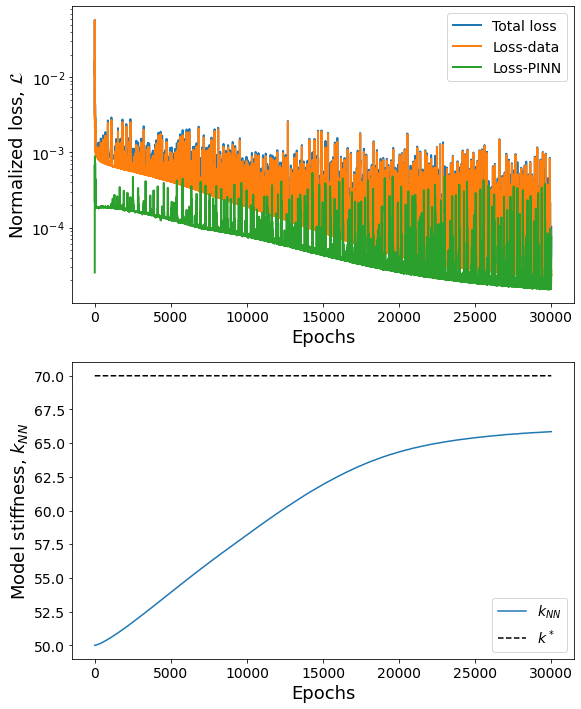

In [193]:
model.load_state_dict(torch.load('pretrain_last_checkpoint.pth'))

df = pd.read_csv('k=70_L=7_N=5_M=1.csv')
positions = df[['r0_x', 'r0_y', 'r1_x', 'r1_y', 'r2_x', 'r2_y', 'r3_x', 'r3_y','r4_x','r4_y']]
forces = df[['rddot1_x','rddot1_y','rddot2_x','rddot2_y','rddot3_x','rddot3_y']]

position_stack = np.vstack((
    positions[['r0_x','r0_y','r1_x','r1_y','r2_x','r2_y']].to_numpy(),
    positions[['r1_x','r1_y','r2_x','r2_y','r3_x','r3_y']].to_numpy(),
    positions[['r2_x','r2_y','r3_x','r3_y','r4_x','r4_y']].to_numpy()
))
forces_stack = np.vstack((
    forces[['rddot1_x','rddot1_y']].to_numpy(),
    forces[['rddot2_x','rddot2_y']].to_numpy(),
    forces[['rddot3_x','rddot3_y']].to_numpy()
))

x_k = torch.from_numpy(position_stack.copy()).float()[::2,:]
y_k = torch.from_numpy(forces_stack.copy()).float()[::2,:]

x_k_coll = x_k.clone().requires_grad_(True)

for p in model.parameters():
    p.requires_grad = True # False

# model.layer_out.requires_grad = True
model.k.requires_grad = True
print(model.k)

model, L_param, L_data_param, L_pinn_param, k_values = train_model(
    model,
    data_loss_fn=lambda model: 1e4*compute_data_loss_force(model, x_k, y_k),
    PINN_loss_fn=lambda model: 1e2*compute_PINN_loss(model, x_k_coll),
    val_loss_fn=lambda model: torch.tensor(0.0),
    learning_rate=1e-3,
    max_epochs=30000,
    weight_decay=1e-3,
)

print(model.k)

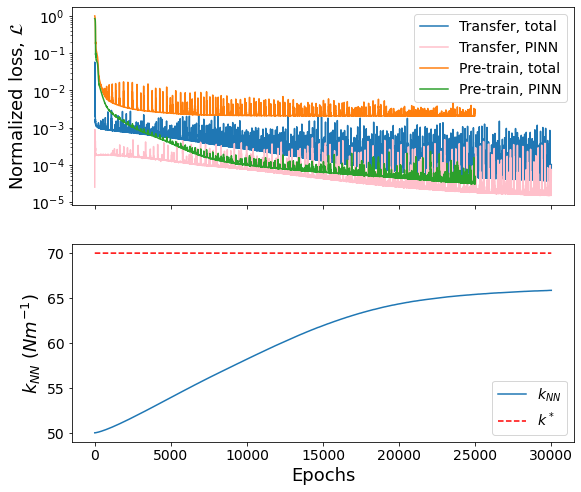

In [204]:
torch.save(model.state_dict(), "retrain_final.pth")

fig, ax = plt.subplots(2,1,figsize=(9,8), sharex='all')

ax[0].semilogy(L_param / L_tr[0], label="Transfer, total")
ax[0].semilogy(L_pinn_param / L_tr[0], label="Transfer, PINN", c="pink")#, c='green')
ax[0].semilogy(L_tr / L_tr[0], label="Pre-train, total")
ax[0].semilogy(L_pinn_tr / L_tr[0], label="Pre-train, PINN")#, c='red')
ax[0].set_ylabel("Normalized loss, $\mathcal{L}$")
# ax[0].set_xlabel("Epochs")
ax[0].legend()

TRUE_K_VALUE = 70.0

ax[1].plot(k_values, label="$k_{NN}$")
ax[1].plot(np.ones_like(np.array(k_values)) * TRUE_K_VALUE, label="$k^*$", linestyle='dashed', color='red')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("$k_{NN}$ $(Nm^{-1})$")
ax[1].legend()


# Compute NN roll-out trajectories

In [206]:
from PINN_integrator import compute_trajectory

# compute NN-predicted closed-loop trajectories
# modify as appropriate:
N_m = 5
xLeft  = (positions.iloc[0,:][['r0_x','r0_y']]).to_numpy()
xRight = (positions.iloc[0,:][['r4_x','r4_y']]).to_numpy()
mass_cols = ['r1_x','r1_y','r2_x','r2_y','r3_x','r3_y']

# # the vector 'x0' contains the initial positions of the *movable* masses
# # i.e. x0.shape = [N_m * 2]
x0 = (positions.iloc[0,:][mass_cols]).to_numpy()
x0dot = np.zeros_like(x0)

y, t = compute_trajectory(x0, x0dot, model, xLeft, xRight)

### Plot NN roll-out trajectories

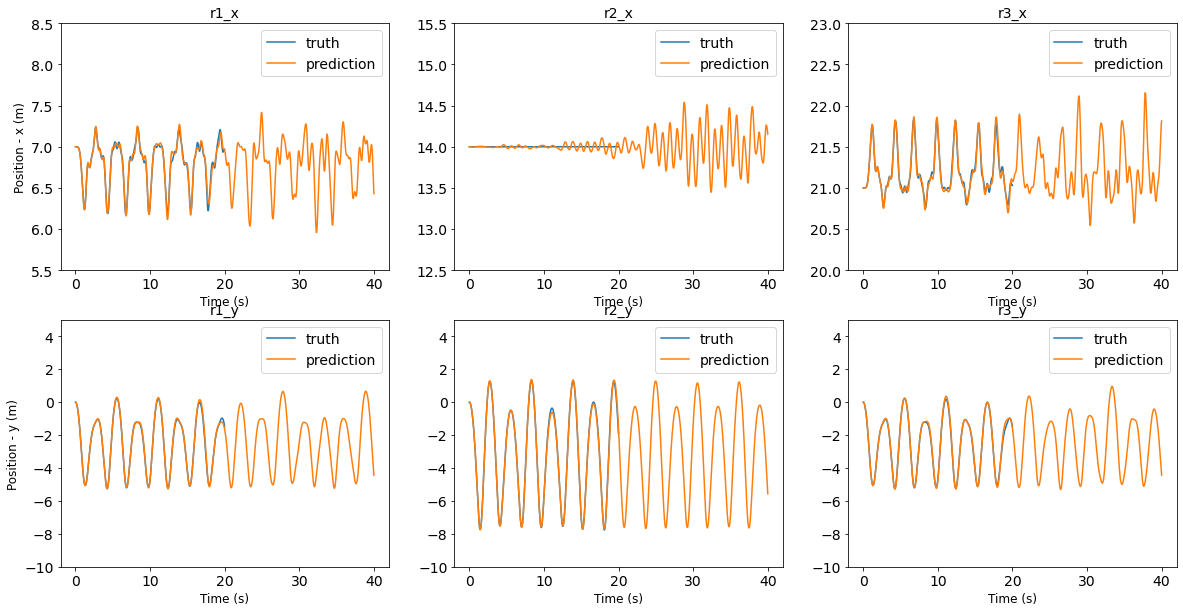

In [211]:
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('axes', labelsize=12)    # fontsize of the x and y labels

fig, ax = plt.subplots(2,3, figsize=(20,10))

ymins_x = [5.5, 12.5, 20]
xrange = 3
ymins_y = [-10,-10,-10]
yrange = 15.0
for i in range(6):
  m = i % 2
  n = i // 2
  curr_ax = ax[m,n]
  curr_ax.plot(df['t'], positions[mass_cols[i]].to_numpy(), label='truth')
  curr_ax.plot(t, y.T[:,i], label='prediction')
  # curr_ax.plot(df['t'], positions[mass_cols[i]].to_numpy() - y.T[:,i], label='truth')
  # curr_ax.set_ylim([-10,10])
  curr_ax.set_title(mass_cols[i])
  curr_ax.set_xlabel('Time (s)')
  # curr_ax.set_xlim([20,30])
  if m == 0:
    curr_ax.set_ylim([ymins_x[n],ymins_x[n] + xrange])
    if n == 0:
      curr_ax.set_ylabel("Position - x (m)")
  else:
    curr_ax.set_ylim([ymins_y[n],ymins_y[n] + yrange])
    if n == 0:
      curr_ax.set_ylabel("Position - y (m)")
  curr_ax.legend()

### Plot NN force predictions

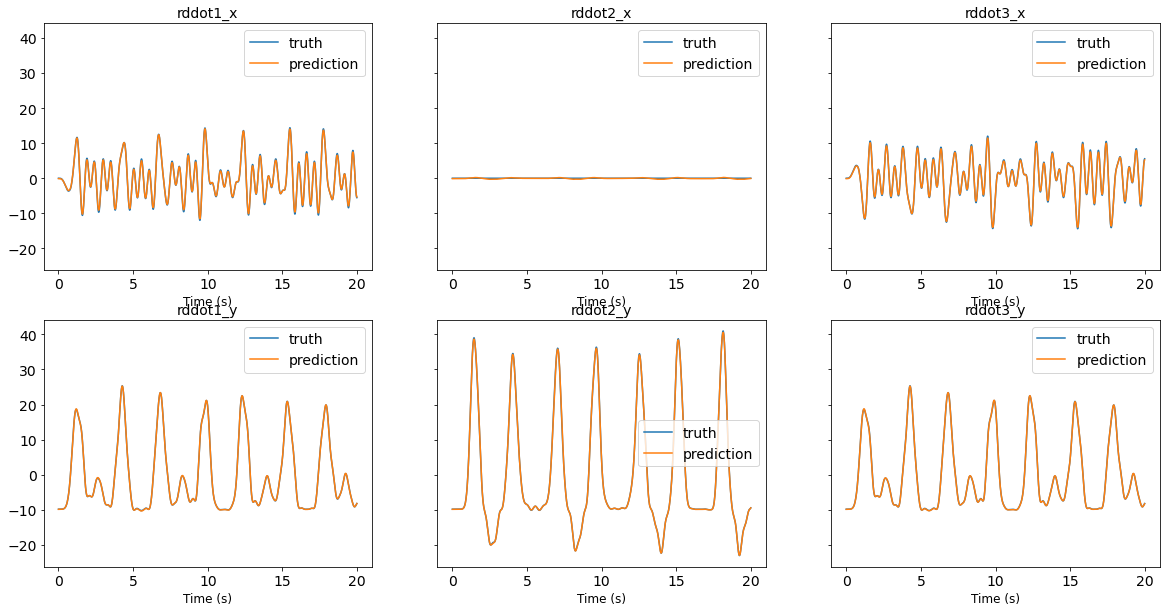

In [213]:
fig, ax = plt.subplots(2,3, figsize=(20,10), sharey='all')
force_cols = ['rddot1_x', 'rddot1_y', 'rddot2_x', 'rddot2_y', 'rddot3_x', 'rddot3_y']

f_pred = model.forward(torch.tensor(position_stack).float().requires_grad_()).detach().numpy() #[:, i].detach().numpy()
Nt = df['t'].size
f_pred = np.hstack((
    f_pred[:Nt],
    f_pred[Nt:2*Nt],
    f_pred[2*Nt:]
))

for i in range(6):
  m = i % 2
  n = i // 2
  curr_ax = ax[m,n]
  curr_ax.plot(df['t'], forces[force_cols[i]].to_numpy(), label='truth')
  curr_ax.plot(df['t'], f_pred[:, i], label='prediction')
  # curr_ax.plot(df['t'], forces[force_cols[i]].to_numpy(), label='truth')
  # curr_ax.plot(df['t'], (f_pred[:, i] - forces[force_cols[i]].to_numpy()), label='prediction')
  # curr_ax.set_ylim([-10,10])
  curr_ax.set_title(force_cols[i])
  curr_ax.set_xlabel('Time (s)')
  # curr_ax.set_xlim([20,30])
  curr_ax.legend()

### Plot NN-predicted force vector field

tensor([-0.1148, -9.8492], grad_fn=<SliceBackward0>)


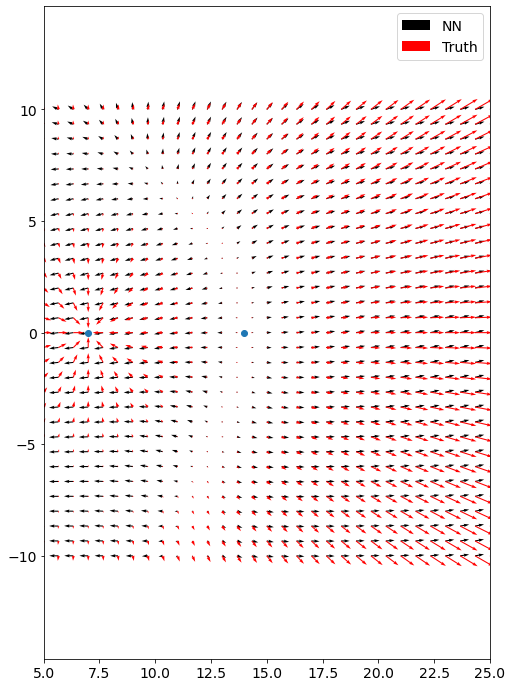

In [214]:
# "x0" is the state where the mass m3 creates zero force
x0 = torch.from_numpy(
    positions.iloc[0,:][['r0_x','r0_y','r1_x','r1_y','r2_x','r2_y']].to_numpy())
N = 31

x_c=15
y_c=0
r_max = 10
xx, yy = np.meshgrid(np.linspace(x_c-r_max, x_c+r_max, N), np.linspace(y_c-r_max, y_c+r_max, N))
plot_pts = np.c_[xx.ravel(), yy.ravel()]

x_inp = torch.zeros(size=(plot_pts.shape[0],6))
x_inp[:, :4] = x0[:4]
x_inp[:, 4:] = torch.from_numpy(plot_pts)
x_inp[0, :] = x0

Fs = model.forward(x_inp).squeeze()
F0 = Fs[0, :]

dF = (Fs - F0).detach().numpy()
# x_inp.shape
dF_truth = (model._get_force_truth(x_inp).squeeze() - torch.tensor([[0.0, -9.81]])).detach().numpy()

fig, ax = plt.subplots(figsize=(8,12))
ax.quiver(xx.ravel(), yy.ravel(), dF[:,0], dF[:,1], label='NN', color='black')
ax.quiver(xx.ravel(), yy.ravel(), dF_truth[:,0], dF_truth[:,1], label='Truth', color='red')
ax.axis('equal')
ax.scatter(x0[0::2], x0[1::2], marker='o')
ax.set_xlim(x_c-r_max, x_c+r_max)
ax.legend()
print(F0)